## Input analysis example: Highway cellular network

### Problem statement
The telecommunication company XPhone has been receiving complaints from its subscribers regarding quality of service (QoS) along a 40 km long highway connecting two major cities. The highway is covered by its cellular telephony network. The company needs to decide whether or not its system guarantees quality of service (QoS) in terms of percentages of dropped calls and blocked calls. Some measurements have been made of the traffic in the network on the highway. Your task is to model and simulate the system to determine whether the system can meet the quality of service requirements, and if so, which fixed channel allocation scheme offers the best service.
### Quality of Service (QoS) Requirements
- Blocked calls < 2%, and
- Dropped calls < 1%

### System Description
The two-way highway is 40 km long. The company uses 20 base stations, each covers a cell with 2 km diameter as shown in the figure below. There is no overlapping of cells. Where the reach of one base station ends, the reach of the next base station starts. Each base station has 10 channels so there are 10 channels available in each cell.

When a subscriber initiates a call from within a cell, a channel in the cell will be allocated to the call. If no free channels are available in the base station, the call is blocked. When a subscriber making a call crosses a cell boundary before the end of the 40-km highway, the channel being used in the current cell is released and a new channel in the new cell has to be acquired: this is called a Handover. If a channel is not available in the new base station during a handover the call is dropped. When a subscriber making a call crosses the end of the 40-km highway (either end), the call will be terminated and the channel being used is released.

A Fixed Channel Allocation (FCA) scheme is used. The company wants you to test at least two FCA schemes:

<ol>
  <li>No channel reservation.</li>
  <li>9 channels are allocated to each cell for new calls and handovers and 1 channel is reserved for handovers when the other 9 channels are not available. This means a new call will not be allocated a channel if there is only one free channel left.</li>
</ol>

The company has provided the following measurements:

- Call initiation times and their first base stations
- Call durations
- Car speeds.

**Assumptions and simplifications**

The traffic volumes in the two directions are the same. This means the two directions of cars travelling along the highway have equal probabilities.
A car maintains the same speed during a call.
The position of the car initiating a call in a cell is uniformly distributed along the section of the highway covered by the base station.
### Task
Analyze the measured data to find what distributions the inter-arrival times of calls, the locations where calls are generated, the call durations, and car speeds follow respectively. You also need to find the parameter values of these distributions. The measured data are provided in `input.xlsx`.

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import expon, norm
import numpy as np
import pandas as pd
from scipy import stats

In [7]:
data = pd.read_excel('input.xlsx')
data.head()

,Arrival no,Arrival time (sec),Base station,Call duration (sec),velocity (km/h)
0,1,0.000000,18,76.133611,125.934254
1,2,0.067744,7,159.056244,95.510881
2,3,0.559184,6,179.465053,127.757456
3,4,0.625319,14,163.108320,134.310552
4,5,1.345066,2,95.054472,112.272359


In [312]:
data.shape

(10000, 5)

### 1) Inter-arrival times

In [8]:
arrival_time = data['Arrival time (sec)']
interarrival_time = arrival_time.diff().dropna()

In [329]:
#look at descriptive stats
interarrival_time.describe()

count    9999.000000
mean        1.369817
std         1.343922
min         0.000025
25%         0.407874
50%         0.961708
75%         1.891807
max        12.498550
Name: Arrival time (sec), dtype: float64

In [95]:
#compare biased / unbiased estimators of std
print('Biased std: %.6f' % interarrival_time.std(ddof=0))
print('Unbiased std: %.6f' % interarrival_time.std(ddof=1))

Biased std: 1.343855
Unbiased std: 1.343922


#### Probability distribution
##### Histogram & kernel density
Plot histogram and try to fit kernel density (smooth line) to detect any bi-modality or another pattern, and to identify potential distributions.

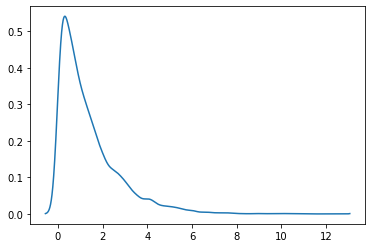

In [324]:
# fit a kernel
import statsmodels.api as sm
kde = sm.nonparametric.KDEUnivariate(interarrival_time)
kde.fit()
plt.plot(kde.support, kde.density, label="KDE from samples")

<AxesSubplot:xlabel='Arrival time (sec)', ylabel='Density'>

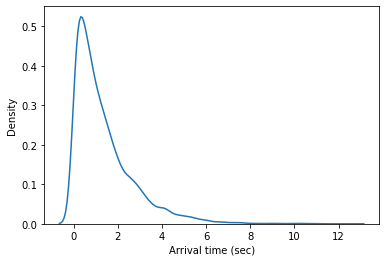

In [323]:
# fit a kernel
import seaborn as sns
sns.kdeplot(interarrival_time)

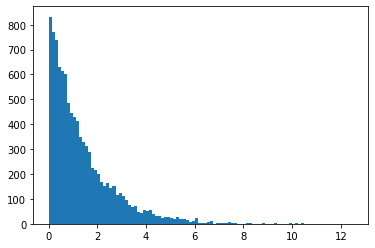

In [328]:
# draw hist
plt.hist(interarrival_time,100)
plt.show()

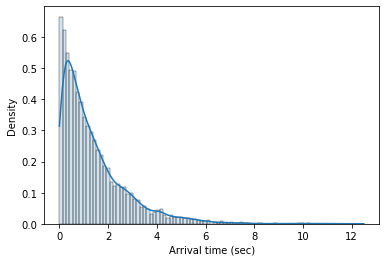

In [325]:
# draw hist and fit a kernel
import seaborn as sns
sns.histplot(interarrival_time, label='Inter Arrival Time',kde=True,stat="density",alpha=0.2)
#sns.distplot(interarrival_time, label='Inter Arrival Time',kde=True,hist=True)
plt.show()

Get help from ACF and PACF graphs to reveal any auto-correlation structure in your data.

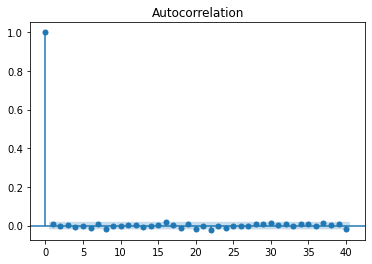

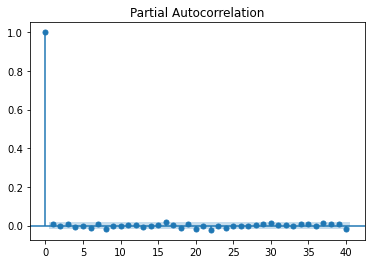

In [240]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(interarrival_time); 
plot_pacf(interarrival_time);

##### Selecting distribution and comparing quantiles
Try Q-Q plots on a number of alternatives to select a distribution family (or a number of potential candidates). Always refer to [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats) documentation to get to know what input parameters need to provided for each distribution.

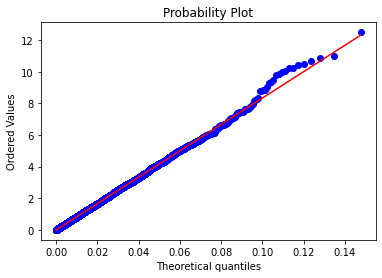

In [12]:
#draw a q-q plot againts various distributions
fig = plt.figure()
ax = fig.add_subplot(111)
#stats.probplot(interarrival_time, dist=stats.norm,sparams=(1,2),plot=ax)
#stats.probplot(interarrival_time, dist=stats.expon,plot=ax)
#stats.probplot(interarrival_time, dist=stats.gamma,sparams=(1,),plot=ax)
stats.probplot(interarrival_time, dist=stats.beta, sparams=(1,60),plot=ax)
plt.show()
#1.0075580035477385,50.91118687221094,2.395382549338611e-05,70.59205633029417

There is in fact an automated way of searching for an appropriate distribution and estimating its parameters (see `distfit()` below). The most suitable distribution is selected as Beta distribution.

#### Goodness-of-fit
##### K-S test on interarrival times

In [321]:
from scipy.stats import kstest
kstest(interarrival_time,'beta',
       [1.0075580035477385,
        50.91118687221094,
        2.395382549338611e-05,
        70.59205633029417])
kstest(interarrival_time,'expon',
       [0.0000,1.369817])

KstestResult(statistic=0.010023150692294924, pvalue=0.2658106043225813)

#### C-S test on interarrival times
Let's choose $k=\sqrt{n}=100$.

In [277]:
import math
k=100
p_j = 1/k
# Obtain 100 class intervals
iat_interval = [0]
iat_mean = interarrival_time.mean()

for i in range(1, k):
    iat_interval.append(expon.ppf(i*p_j, scale=iat_mean))
    
iat_interval.append(math.inf)

In [278]:
# Calculate the test statistic
n = 10000
test_stat = 0
for i in range(k):
    N_j = len(interarrival_time[(iat_interval[i] <= interarrival_time) & (interarrival_time < iat_interval[i+1])])
    test_stat += (N_j - n * p_j) ** 2 / (n * p_j)

print("Test Statisic:", test_stat)

Test Statisic: 111.64999999999999


#### Checking for inter-dependence

### 2) Call durations
*Repeat the same analysis above for call durations.*

In [302]:
call_duration = data['Call duration (sec)']

### Appendix: Distfit library

In [11]:
#%pip install distfit
import numpy as np
from distfit import distfit

# Generate 10000 normal distribution samples with mean 0, std dev of 3 
#X = np.random.normal(0, 3, 10000)
#X = norm.rvs(0,3,10000)
X = interarrival_time

# Initialize distfit
dist = distfit()

# Determine best-fitting probability distribution for data
dist.fit_transform(X)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.0 sec] [RSS: 0.4178891] [loc=1.370 scale=1.344]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.0026379] [loc=0.000 scale=1.370]
[distfit] >[pareto    ] [0.90 sec] [RSS: 0.0088465] [loc=-12416010.545 scale=12416010.546]
[distfit] >[dweibull  ] [0.41 sec] [RSS: 0.3313773] [loc=1.102 scale=0.978]
[distfit] >[t         ] [0.24 sec] [RSS: 0.2815180] [loc=1.004 scale=0.811]
[distfit] >[genextreme] [0.35 sec] [RSS: 0.0733645] [loc=0.643 scale=0.640]
[distfit] >[gamma     ] [0.40 sec] [RSS: 0.0032024] [loc=0.000 scale=1.456]
[distfit] >[lognorm   ] [0.38 sec] [RSS: 0.0310318] [loc=-0.111 scale=0.998]
[distfit] >[beta      ] [0.35 sec] [RSS: 0.0020062] [loc=0.000 scale=70.592]
[distfit] >[uniform   ] [0.0 sec] [RSS: 1.1212076] [loc=0.000 scale=12.499]
[distfit] >[loggamma  ] [0.49 sec] [RSS: 0.4267621] [loc=-538.282 scale=69.087]
[distfit] >Compute confidence interval [parametric]


{'model': {'distr': <scipy.stats._continuous_distns.beta_gen at 0x24dd041d190>,
  'stats': 'RSS',
  'params': (1.0075580035477385,
   50.91118687221094,
   2.395382549338611e-05,
   70.59205633029417),
  'name': 'beta',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x24dd31d0e20>,
  'score': 0.002006186576842647,
  'loc': 2.395382549338611e-05,
  'scale': 70.59205633029417,
  'arg': (1.0075580035477385, 50.91118687221094),
  'CII_min_alpha': 0.07299359822860171,
  'CII_max_alpha': 4.052799973917255},
 'summary':          distr     score  LLE              loc            scale  \
 0         beta  0.002006  NaN         0.000024        70.592056   
 1        expon  0.002638  NaN         0.000025         1.369792   
 2        gamma  0.003202  NaN         0.000025         1.455615   
 3       pareto  0.008847  NaN -12416010.545494  12416010.545519   
 4      lognorm  0.031032  NaN        -0.111492         0.998083   
 5   genextreme  0.073365  NaN         0.642732         0.6396

In [ ]:
print(dist.summary)

[distfit] >plot..


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nbeta\na=1.00756, b=50.9112, loc=2.39538e-05, scale=70.5921'}, xlabel='Values', ylabel='Frequency'>)

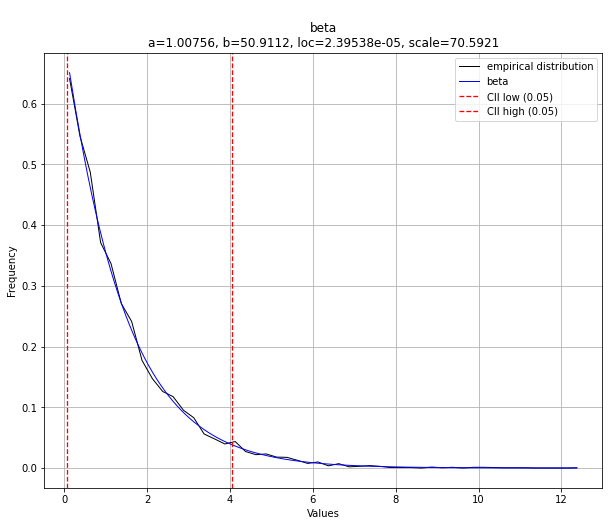

In [13]:
dist.plot()

### Resources
- Case adopted from [https://github.com/ritikbhatia](https://github.com/ritikbhatia).
- Best fit: [https://www.kdnuggets.com/2021/09/determine-best-fitting-data-distribution-python.html](https://www.kdnuggets.com/2021/09/determine-best-fitting-data-distribution-python.html)